In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as img
import sklearn
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as ss
import time
from numba import jit

We will begin by working with the following image of a checkerboard

In [2]:
im = img.imread('ortonStripes.jpg')
imbw = 0.2126*im[:,:,0] + 0.7152*im[:,:,1] + 0.0722*im[:,:,2]

In [3]:
imbw2 = imbw.copy()
#imbw = imbw2[40:60,40:60]

<IPython.core.display.Javascript object>


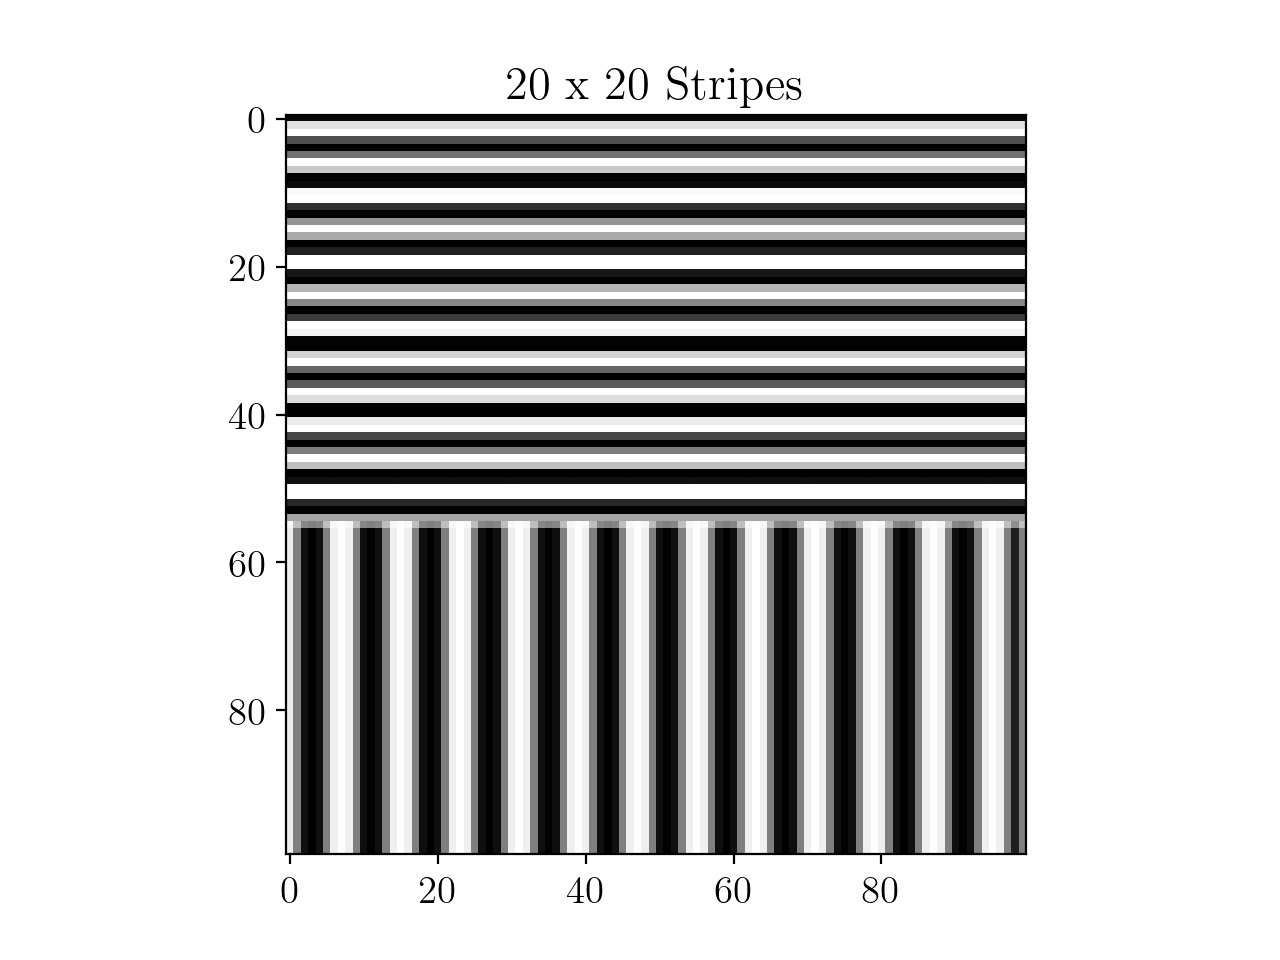

Text(0.5,1,'20 x 20 Stripes')

In [4]:
plt.figure()
plt.imshow(imbw,cmap='gray') #Black and White Image 
plt.title('20 x 20 Stripes')

Lets try to blur this image using a Gaussian Blur Kernel

We will first try a Gaussian Blur, which uses a 2D Gaussian Kernel. We will assume that this is a circular Gaussian.

The continuous point spread function with standard deviation
$$
f(x,y) = \frac{1}{2 \pi \sigma^2} \exp \left (   -\frac{1}{2}(x - \mu)^2 - \frac{1}{2}(y - \mu)^2) \right )
$$
When discretizing this distribution, we choose the interval to span 2 standard deviations in each direction. Additionally, we must choose how many pixels this kernel will integrate over, which will be determined by the size of the discretization

In this demo, we will try this with $\mu = 0$ and $\sigma^2 = 1$

In [5]:
@jit #Numba jit compiler
def circular_gaussian(mean,sigma,kdim):
    x = np.linspace(-2*sigma,2*sigma,kdim)
    y = np.linspace(-2*sigma,2*sigma,kdim)
    xx,yy = np.meshgrid(x,y)
    kernel = (1/(2*np.pi*sigma**2))*np.exp(-0.5*np.power((xx-mean)/sigma,2) - 0.5*np.power((yy-mean)/sigma,2))
    kernel = kernel/np.sum(kernel) #Normalize Kernel
    return xx,yy,kernel

In [6]:
sigma = 1
var = sigma**2
kdim = 6
xx, yy, kernel = circular_gaussian(mean = 0,sigma = sigma,kdim = kdim)

<IPython.core.display.Javascript object>


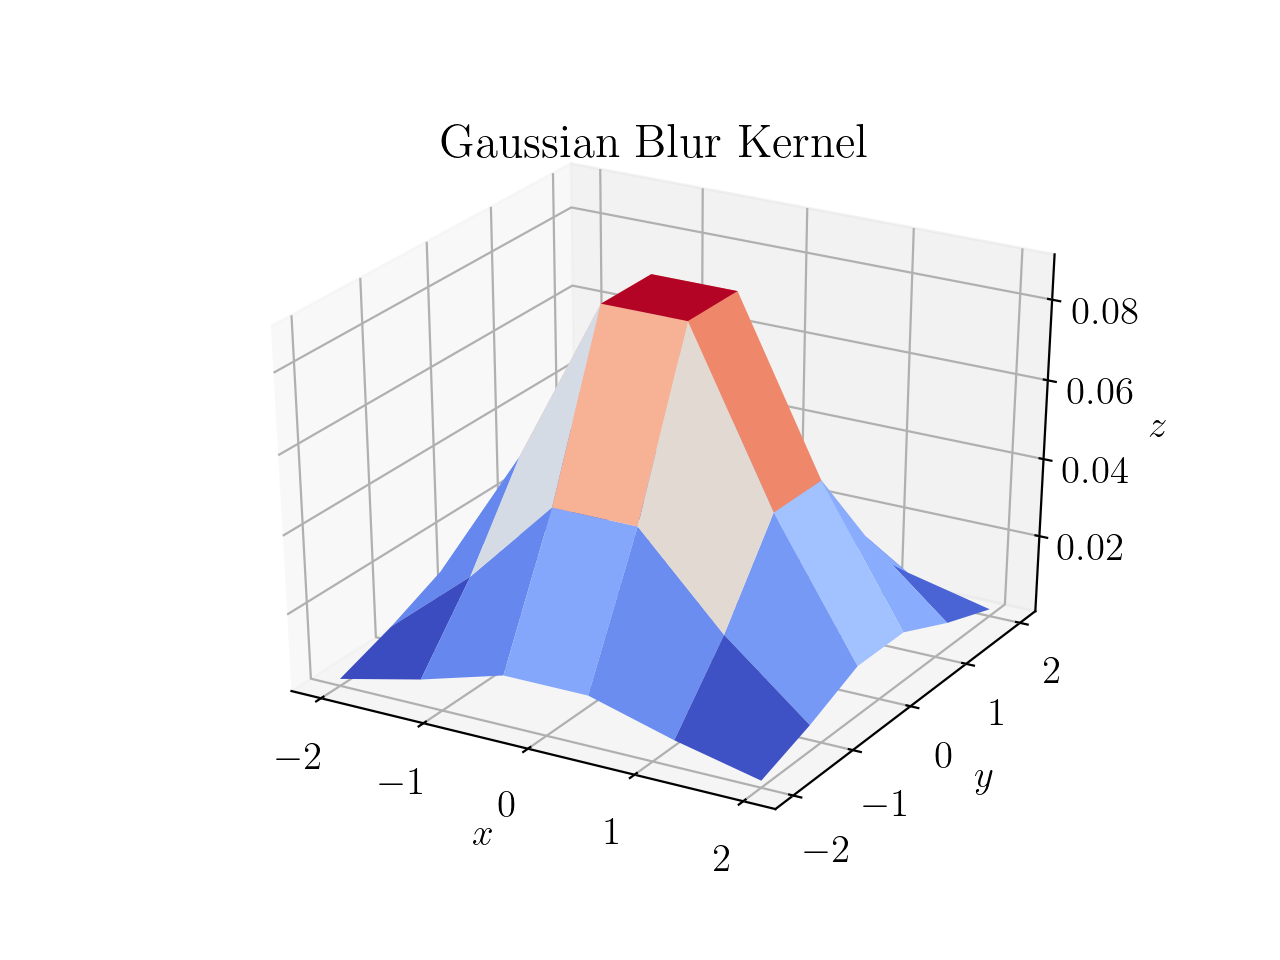

Text(0.5,0,'$z$')

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(xx,yy,kernel,cmap='coolwarm')
plt.title("Gaussian Blur Kernel")
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_zlabel('$z$')

In [8]:
imconv = ss.convolve2d(imbw,kernel) #Convolved image

<IPython.core.display.Javascript object>


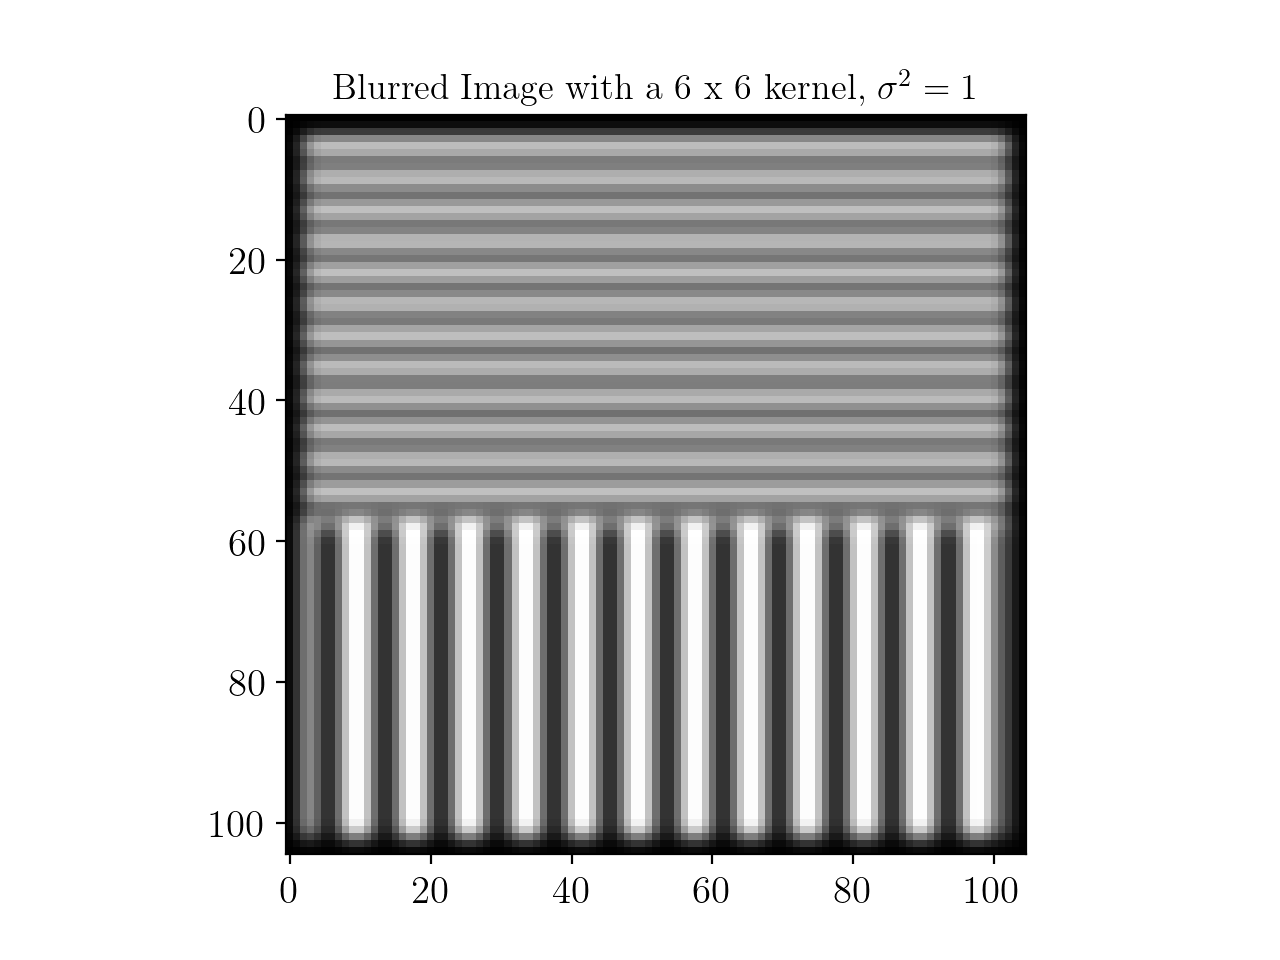

Text(0.5,1,'Blurred Image with a 6 x 6 kernel, $\\sigma^2 = 1$')

In [9]:
plt.figure()
plt.imshow(imconv,cmap='gray') 
plt.title("Blurred Image with a %d x %d kernel, $\sigma^2 = %d$"%(kdim,kdim,var),fontsize=13)

Our goal is to implement the 2-Dimensional Richardson Algorithm, which I will show an explanation of here

Given a degraded image, $H$, of size $N \times M$, and a (normalized) blurring kernel $S$, which is of size $K \times K$, we will need to recover the original image $W$, which must be of size $(N-K+1) \times (M - K +1)$. 

We will say $H,W,S$ are probability frequency functions, where the events describe energy at cells of the image, and that $P(W_{ij}) = \frac{W_{ij}}{\sum W}$

By Bayes' Theorem
\begin{align*}
P(W_{ij} | H_{nm}) &= \frac{P(H_{nm}|W_{ij})}{\sum \limits_{k,l}P(H_{nm} |W_{kl}) \cdot P(W_{kl})}
\end{align*}

Also

$$
P(W_i) = \sum \limits_{n,m} P(W_{ij}|H_{nm})\cdot P(H_{nm})
$$

Substituting in for $P(W_{ij} | H_{nm})$, we see that 

$$
P(W_{ij}) = \sum \limits_{n=0}^{N-1} \sum \limits_{m=0}^{M-1} \frac{P(H_{nm} | W_{ij}) P(H_{nm}) P(W_{ij})}{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} P(H_{nm}|W_{\ell k}) \cdot P(W_{\ell k})}
$$
To find the conditional probability $P(H_{nm}|W_{ij})$, consider an event at $W_{ij}$. We will denote this by a two-dimensional impulse, so $W_{ij} = \delta(i,j)$ Then by the sifting property,
\begin{align*}
H_{nm} &= \sum \limits_{p,q} S_{n-p,m-q} \delta(i,j) \\
H_{nm} &= S_{n-i,m-j}
\end{align*}
Therefore, 
\begin{align*}
P(H_{nm}|W_{ij}) &= \frac{S_{n-i,m-j}}{\sum \limits_{n,m} S_{n-i,m-j}} = P(S_{n-i,m-j})  \\
\end{align*}

\begin{align*}
P(W_{ij}) &= P(W_{ij}) \sum \limits_{n=0}^{N-1} \sum \limits_{m=0}^{M-1} \frac{P(S_{n-i,m-j}) P(H_{nm}) }{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} P(S_{n-\ell,m-k}) \cdot P(W_{\ell k})}
\end{align*}
Since convolution preserves total sum, we can cancel out the probabilites, and we will turn this into an iteration, where $r$ is the iteration number.

\begin{align*}
W_{ij,r+1} &= W_{ij,r} \sum \limits_{n=0}^{N-1} \sum \limits_{m=0}^{M-1} \frac{S_{n-i,m-j} H_{nm} }{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} S_{n-\ell,m-k}  W_{\ell k,r}}
\end{align*}
Since we we only need to consider positive indices of $S$, we can make this iteration by adjusting the summation indices.

\begin{align*}
W_{ij,r+1} &= W_{ij,r} \sum \limits_{n=i}^{N-1} \sum \limits_{m=j}^{M-1} \frac{S_{n-i,m-j} H_{nm} }{ \sum \limits_{\ell = 0}^{I-1} \sum \limits_{k=0}^{J-1} S_{n-\ell,m-k}  W_{\ell k,r}}
\end{align*}

This is the iteration we will compute

In [10]:
@jit
def compute_denominator(S,W,point,iteration):
    #int1 and int2 are intervals to sum over
    sum = 0
    K,L = S.shape
    I,J = W.shape[0:2]
    n,m = point
    a = n - K + 1
    d = m - L + 1
    for l in range(n-K +1, np.min([n,I])):
        temp = 0
        for k in range(m - L + 1,np.min([m,J])):
            temp += S[n-l,m-k]*W[l,k,iteration]
        sum += temp
    return sum        

In [13]:
@jit 
def compute_iteration(S,W,H,point,iteration):
    """ 
    S is the kernel
    W is the original image 
    H is the degraded image
    point is the (i,j) coordiate to update on W
    iteration is the iteration number
    """
    i,j = point
    (N,M) = H.shape
    (K,L) = S.shape
    sum = 0
    for n in range(i,i + K):
        temp = 0
        for m in range(j, j + L):
            num = S[n-i,m-j]*H[n,m]

            den = compute_denominator(S,W,(n,m),iteration)
            print(H[n,m],den)
            temp += num/den
        sum += temp
    
    return W[i,j,iteration]*sum

In [14]:
@jit
def richardson_deconvolution(S,H,num_its):
    
    #First compute parameters
    (N,M) = H.shape #Dimensions of the degraded image
    K,L = S.shape #Size of the Kernel
    I = N - K + 1 # Dimensions of the original image
    J = M - K + 1
    II = np.sum(H) # Total energy of degraded image
    W = np.ones((I,J,num_its)) #This will force the initial condition as the first iteration
    for r in range(num_its - 1):
        start = time.time()
        for i in range(I):
            for j in range(J):
                point = (i,j)
                W[i,j,r+1] = compute_iteration(S,W,H,point,r)
        end = time.time()
        print("Iteration %d: time"%r, end-start)
    print('-'*80)

    return W

<IPython.core.display.Javascript object>


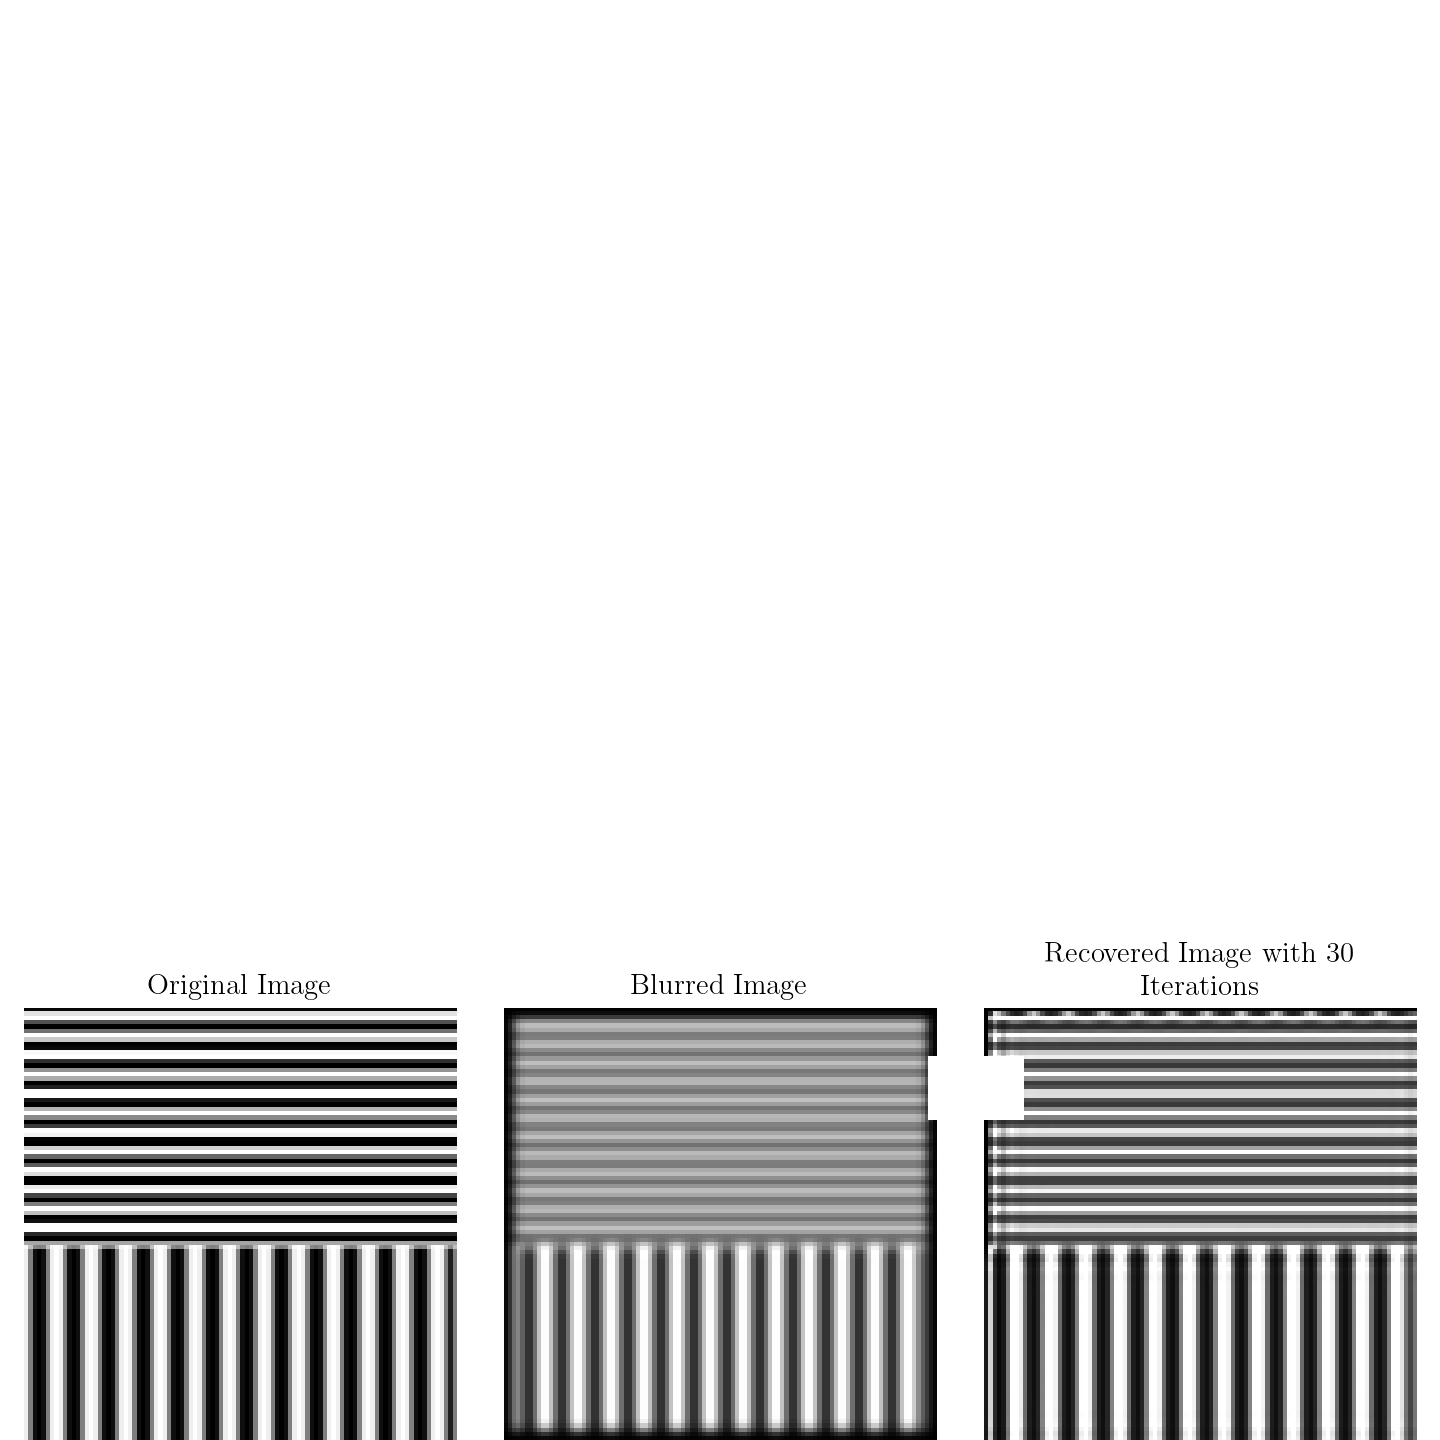

In [56]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (9,9))
ax3.imshow(W[:,:,-1],cmap='gray',vmin = imbw.min(),vmax = imbw.max()) 
ax3.axis('off')
ax2.imshow(imconv,cmap='gray')
ax2.axis('off')
ax2.set_title("Blurred Image",fontsize=13)
ax1.imshow(imbw,cmap='gray')
ax1.axis('off')
ax1.set_title("Original Image",fontsize = 13)
ax3.set_title("Recovered Image with %d \n Iterations"%num_its,fontsize = 13)

fig.subplots_adjust(wspace=0.0, hspace=0,
                    top=0.3, bottom=0.0, left= 0, right=1)

<IPython.core.display.Javascript object>


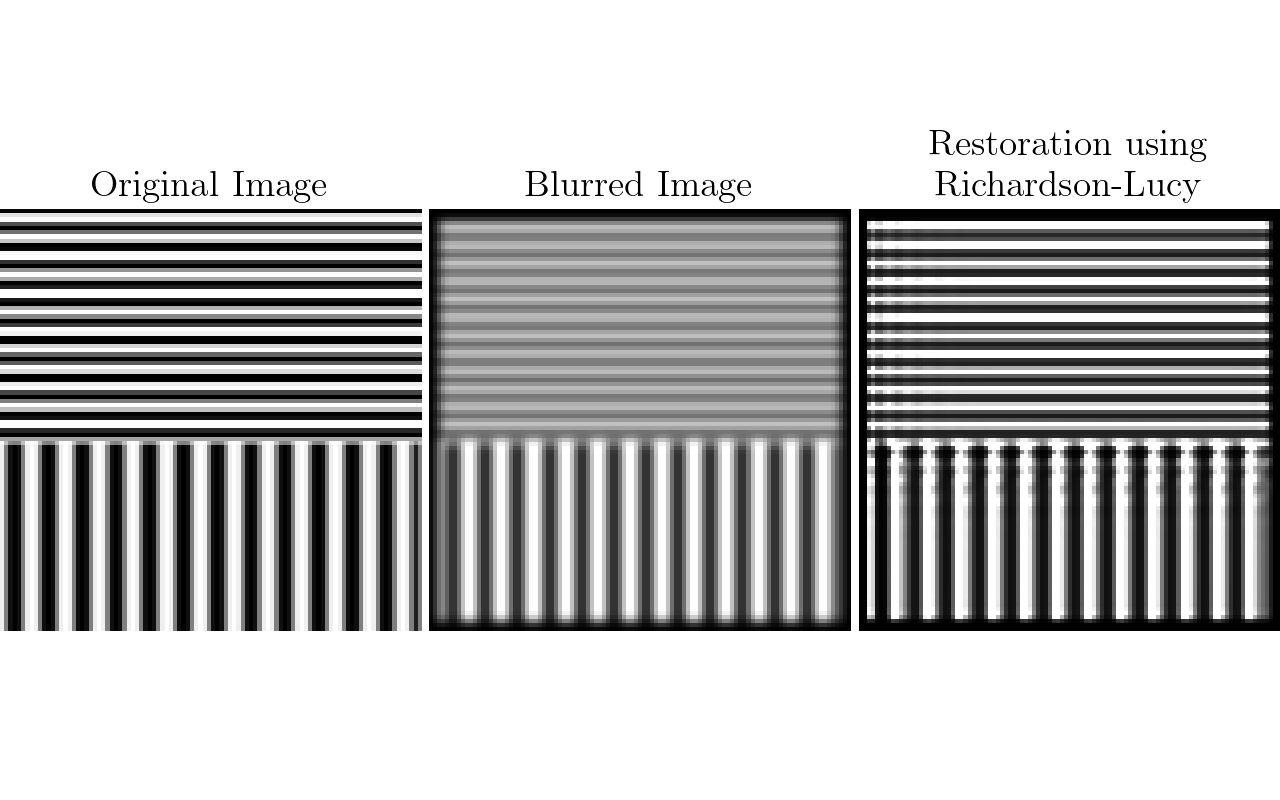

In [61]:
#Built in Function
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(imconv, kernel, iterations=30,clip = False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(imbw)
ax[0].set_title('Original Image')

ax[1].imshow(imconv, vmin = imconv.min(),vmax = imconv.max())
ax[1].set_title('Blurred Image')

ax[2].imshow(deconvolved_RL,vmin = imconv.min(),vmax = imconv.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()